In [142]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split 

import warnings
warnings.filterwarnings('ignore')
import pickle

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score

In [143]:
#objective : to predict the insurance premium on the basis of the features given 

In [144]:
#importing and reading the csv file
df=pd.read_csv(r"C:\Users\User\Documents\insurance premium\insurance.csv")
df.head(2)

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55


In [145]:
#checking for null values
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

In [146]:
numerical_features=df[['age','bmi','expenses']]

In [147]:
#creating a function to check for outliers
def var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), x.var(), x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()],
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

num_summary=numerical_features.apply(lambda x: var_summary(x)).T
num_summary

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
age,1338.0,0.0,52459.00,39.207025,39.00,14.049960,1.974014e+02,18.00,18.0000,18.0000,19.000,27.0000,39.00,51.000,59.000,62.000,64.0000,64.00
bmi,1338.0,0.0,41030.40,30.665471,30.40,6.098382,3.719027e+01,16.00,17.9370,21.2700,23.000,26.3000,30.40,34.700,38.630,41.100,46.3890,53.10
expenses,1338.0,0.0,17755825.19,13270.422414,9382.03,12110.011240,1.466524e+08,1121.87,1252.9761,1757.7545,2346.535,4740.2875,9382.03,16639.915,34831.716,41181.826,48537.4806,63770.43


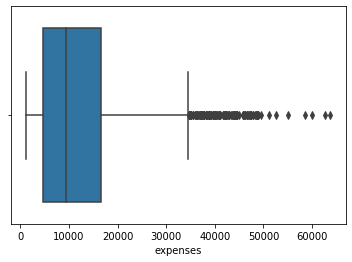

In [148]:
#for variables expenses and bmi it is clearly visible that there are outliers in the data and hence, 
#we are capping the p99 and p1 values
ax=sns.boxplot(df['expenses'])
plt.show()

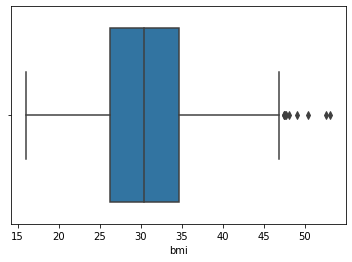

In [149]:
#checking for outliers in bmi
ax=sns.boxplot(df['bmi'])
plt.show(ax)

In [150]:
#after capping the variables at p1 and p99
df['expenses']=df['expenses'].clip(1252.9761,48537.4806)
df['bmi']=df['bmi'].clip(17.9370,46.3890)

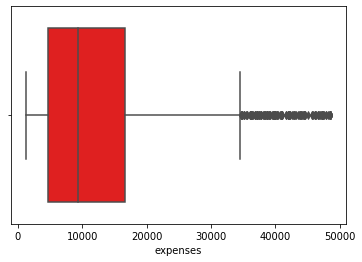

In [151]:
#now again plotting the boxplots for these variables after capping the values at p1 and p99
ax=sns.boxplot(df['expenses'], color='r')
plt.show()

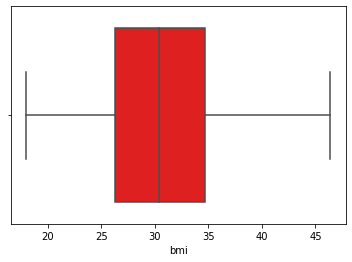

In [152]:
ax=sns.boxplot(df['bmi'], color='r')

1.4466411172313156


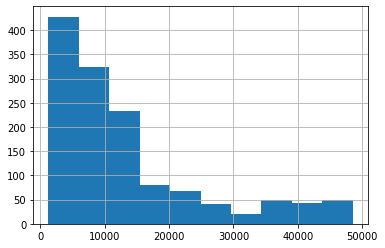

In [153]:
#checking the distribution and skewness of expenses, age and bmi
df['expenses'].hist()
print(df['expenses'].skew())

The graph shows that the expenses is right tailed/skewed. Also, the skewness calculated is positive (1.446)

0.05567251565299186


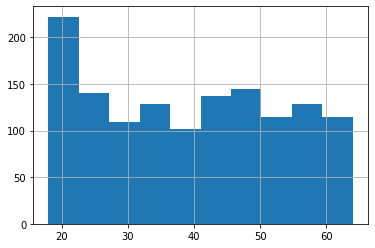

In [154]:
df['age'].hist()
print(df['age'].skew())

0.22842470275898163


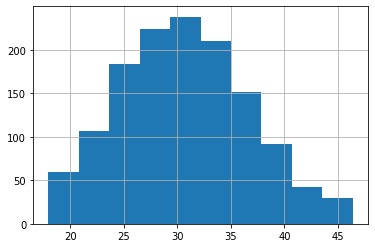

In [155]:
df['bmi'].hist()
print(df['bmi'].skew())

In [156]:
#getting dummy variables for sex and smoker
df_1=pd.get_dummies(data=df,columns=['sex','smoker'],drop_first=True)
df_1.rename(columns={'sex_male':'gender','smoker_yes':'smoker'},inplace=True)

In [157]:
df_1.head(2)

,age,bmi,children,region,expenses,gender,smoker
0,19,27.9,0,southwest,16884.92,0,1
1,18,33.8,1,southeast,1725.55,1,0


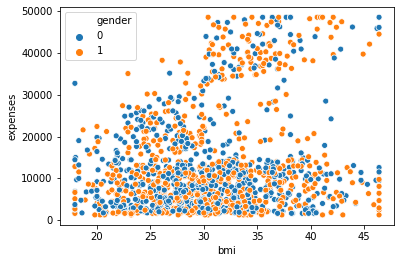

In [158]:
ax=sns.scatterplot(data=df_1, x='bmi', y='expenses',hue='gender',color='blue')

This graph shows that for bmi greater than 30, the expenses are considerably high.
For bmi less than 30, the expenses ranges from 0-3000. However, for bmi between 30-45 there are a lot of people ith expenses higher than 3000.

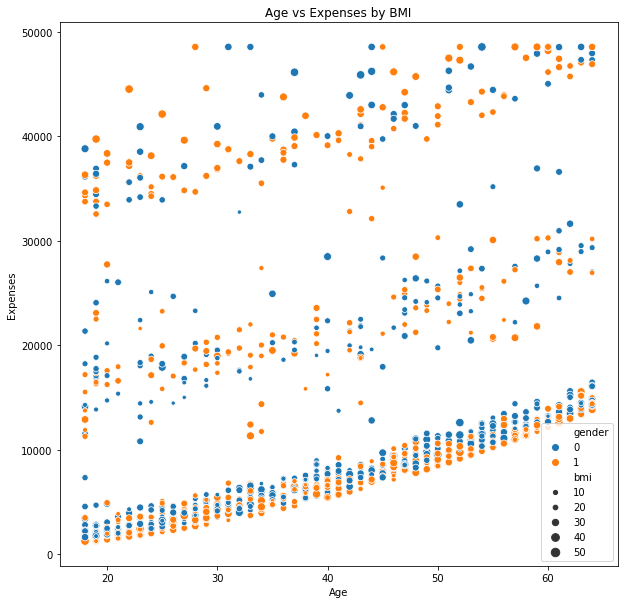

In [159]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x='age',y='expenses',hue = 'gender',size = 'bmi', data=df_1)
ax = ax.set_title("Age vs Expenses by BMI")
plt.xlabel("Age")
plt.ylabel("Expenses")
plt.show(ax)

The graph shows linear relationship between expenses and age. For people with bmi higher than 30, the medical expenses averages from 3000-5000.

In [160]:
print("**the graph shows positive linear relatipnship between age and expenses. As age is rising, expenses are also rising")
print(df[['age','expenses']].corr())
print('**the correlation coefficient also given a positive output of 0.301, indicating positive relationship between the two variables')

**the graph shows positive linear relatipnship between age and expenses. As age is rising, expenses are also rising
               age  expenses
age       1.000000  0.301214
expenses  0.301214  1.000000
**the correlation coefficient also given a positive output of 0.301, indicating positive relationship between the two variables


In [161]:
#lets check the relationship between region and other variables

#to check the relationship we need to assign values to region to make it a numerical variable
df_1['region']=df_1['region'].astype('category').cat.codes

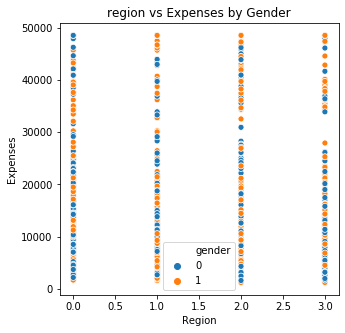

In [162]:
plt.figure(figsize=(5,5))
ax = sns.scatterplot(data=df_1,x='region',y='expenses',hue = 'gender',color='blue')
ax = ax.set_title("region vs Expenses by Gender")
plt.xlabel("Region")
plt.ylabel("Expenses")
plt.show(ax)

The graph shows that the expenses in all the four regions are more or less equa; for both men and women.

In [163]:
df_1.head(3)

,age,bmi,children,region,expenses,gender,smoker
0,19,27.9,0,3,16884.92,0,1
1,18,33.8,1,2,1725.55,1,0
2,28,33.0,3,2,4449.46,1,0


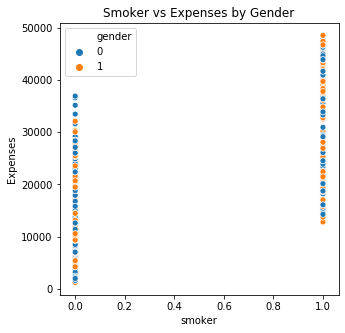

In [164]:
plt.figure(figsize=(5,5))
ax = sns.scatterplot(data=df_1,x='smoker',y='expenses',hue = 'gender',color='blue')
ax = ax.set_title("Smoker vs Expenses by Gender")
plt.xlabel("smoker")
plt.ylabel("Expenses")
plt.show(ax)

The plot shows that medical expenses for people who smoke as compared to people who do not smoke is very high with a base value of more than 1000 and can go as high as 5000 got women and 4500 for men approximately. Where for people who do not smoke the medical expenses can go as high as 3800 for men and 4200 for women approximately.

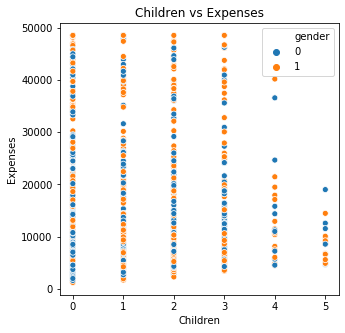

In [165]:
plt.figure(figsize=(5,5))
ax = sns.scatterplot(data=df_1,x='children',y='expenses',hue='gender',color='blue')
ax = ax.set_title("Children vs Expenses")
plt.xlabel("Children")
plt.ylabel("Expenses")
plt.show(ax)

Graph shows that the medical expenses are almost same for people with uptp 3 kids. However, people with 3 kids usually have a higher expenses on men as comapred to women. And people with 4 or 5 children have almost have of expenses as compared to people with 3 or less children.

In [166]:
#checking for correlation between different variables
df_1.corr()

,age,bmi,children,region,expenses,gender,smoker
age,1.000000,0.111371,0.042469,0.002127,0.301214,-0.020856,-0.025019
bmi,0.111371,1.000000,0.013505,0.156984,0.197339,0.044897,0.003030
children,0.042469,0.013505,1.000000,0.016569,0.070093,0.017163,0.007673
region,0.002127,0.156984,0.016569,1.000000,-0.006321,0.004588,-0.002181
expenses,0.301214,0.197339,0.070093,-0.006321,1.000000,0.058127,0.790189
gender,-0.020856,0.044897,0.017163,0.004588,0.058127,1.000000,0.076185
smoker,-0.025019,0.003030,0.007673,-0.002181,0.790189,0.076185,1.000000


###the tables shows relatively high correlation between expenses-age of 0.3, as we calculated before.Alos, between expenses-bmi of 0.2
###the tables show a very high relationship between expenses-smoker, as we saw in the scatter plot.

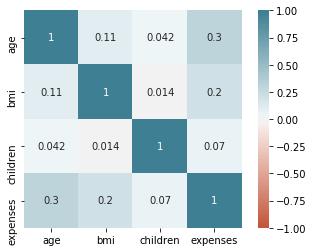

In [167]:
sns.heatmap(df.corr(), vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, annot=True)

In [168]:
#creating linear regression model

# Linear Regresion###

In [169]:
#lr=LinearRegression()

In [170]:
y=df_1['expenses']
target=df_1[['age','bmi','children','region','gender',
       'smoker']]
X=target

In [171]:
train_x,test_x,train_y,test_y=train_test_split( X, y, test_size=0.2, random_state=0 )
print(train_x.count())
print(train_y.count())

age         1070
bmi         1070
children    1070
region      1070
gender      1070
smoker      1070
dtype: int64
1070


In [172]:
#lr without using grid search
lr=LinearRegression()
lr.fit(train_x,train_y)

LinearRegression()

In [173]:
print("coefficients:", lr.coef_ )

coefficients: [ 2.51784574e+02  3.24012358e+02  4.56328731e+02 -2.74912181e+02
  7.08043966e+00  2.32942764e+04]


In [174]:
y_pred=lr.predict(test_x)
df_2=pd.DataFrame({'Actual': test_y, 'Predicted': y_pred})
df_2['Difference between Actual and Predicted']=df_2['Actual']-df_2['Predicted']
df_2.head(5)

,Actual,Predicted,Difference between Actual and Predicted
578,9724.53,11032.590195,-1308.060195
610,8547.69,9782.289182,-1234.599182
569,45702.02,37695.609944,8006.410056
1034,12950.07,16049.048323,-3098.978323
198,9644.25,6946.671282,2697.578718


In [175]:
print("R2 score:", r2_score(test_y,y_pred))
print('MSE score:', mean_squared_error(test_y,y_pred))

R2 score: 0.8016882967113343
MSE score: 31158497.66854995


In [176]:
#predicting y-pred-train data
y_pred_train=lr.predict(train_x)
print("R2 score :",r2_score(train_y, y_pred_train))
print("Mean Squared Error:",mean_squared_error(train_y,y_pred_train))

R2 score : 0.7434601385882434
Mean Squared Error: 35599931.63631167


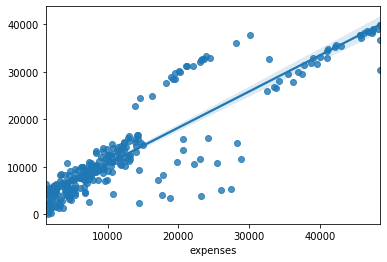

In [177]:
#plotting the regression graph for test data
sns.regplot(x=test_y,y=y_pred, data=df_1)

In [178]:
#plt.scatter(x=test_y, y=y_pred)

In [179]:
#sns.distplot((y_pred), bins=10)

In [180]:
#saving model and training set as a pickle file
pickle.dump(train_x, open('insscaler.pkl', 'wb'))
pickle.dump(lr,open('insmodel.pkl','wb'))

# Checking model for Overfitting/underfitting using Ridge, Lasso, Elastic Regression

In [181]:
from sklearn.model_selection import cross_val_score
#function to get cross validation scores
def get_cv_scores(model):
    scores = cross_val_score(model,
                             train_x,
                             train_y,
                             cv=5,
                             scoring='neg_mean_squared_error')
    
    print('CV Mean/ R2:', np.mean(scores))
    print('STD: ', np.std(scores))

In [182]:
#simple linear regression model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

Stdscaler=StandardScaler()

train_xs=Stdscaler.fit_transform(train_x)
test_xs=Stdscaler.transform(test_x)

lr=LinearRegression().fit(train_xs,train_y)
ytest_pred_lr=lr.predict(test_xs)
ytrain_pred_lr=lr.predict(train_xs)
get_cv_scores(lr)
print("MSE Train:",mean_squared_error(train_y,ytrain_pred_lr))
print("MSE Test:",mean_squared_error(test_y,ytest_pred_lr))


CV Mean/ R2: -36059602.33565632
STD:  3982004.0229985793
MSE Train: 35599931.63631168
MSE Test: 31158497.66854995


In [190]:
#ridge regression
from sklearn.linear_model import Ridge

ridge=Ridge()
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(alpha=alpha)
print(param_grid)
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(train_xs,train_y)
print(grid_search.best_score_)
print(grid_search.best_params_)

{'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
Fitting 5 folds for each of 7 candidates, totalling 35 fits
-36059315.70337887
{'alpha': 1}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.0s finished


In [196]:
#Putting alpha=1 in ridge regression and calculating mse
ridge=Ridge(alpha=1).fit(train_xs,train_y)

pred_ytest_ridge=ridge.predict(test_xs)
pred_ytrain_ridge=ridge.predict(train_xs)

#get cross val scores

get_cv_scores(ridge)
print('MSE Test:',mean_squared_error(test_y,pred_ytest_ridge))
print('MSE Train:',mean_squared_error(train_y,pred_ytrain_ridge))
print("R2 Test:", r2_score(test_y,pred_ytest_ridge))
print('R2 Train:', r2_score(train_y,pred_ytrain_ridge))

CV Mean/ R2: -36063371.76004181
STD:  3990261.2766874027
MSE Test: 31171095.24583005
MSE Train: 35600025.639326304
R2 Test: 0.8016081180379495
R2 Train: 0.7434594611846856


In [197]:
#using lasso regression (l1) regularization
from sklearn.linear_model import Lasso
lasso=Lasso()

#finding optimal alpha using grid search
alpha=[0.001,0.01,0.1,1,10,100,1000]
param_grid=dict(alpha=alpha)

grid=GridSearchCV(estimator=lasso,param_grid=param_grid,scoring='r2', verbose=1, n_jobs=-1)
grid_result=grid.fit(train_xs,train_y)

print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.1s finished


Best Score:  0.7377816469057322
Best Params:  {'alpha': 10}


In [198]:
#putting alpha as 10 and calculating the regression value
lasso=Lasso(alpha=10).fit(train_xs,train_y)
pred_ytest_lasso=lasso.predict(test_xs)
pred_ytrain_lasso=lasso.predict(train_xs)
get_cv_scores(lasso)
print('MSE Test:',mean_squared_error(test_y,pred_ytest_lasso))
print('MSE Train:',mean_squared_error(train_y,pred_ytrain_lasso))
print('R2 test:',r2_score(test_y,pred_ytest_lasso))
print('R2 train:',r2_score(train_y,pred_ytrain_lasso))

CV Mean/ R2: -36050626.215045646
STD:  3989338.915090255
MSE Test: 31187993.17930252
MSE Train: 35600450.78018393
R2 test: 0.8015005692721319
R2 train: 0.7434563975390076


In [206]:
#checking how the features have transformed
for coef,col in enumerate(train_x.columns):
    print(f'{col}: {lasso.coef_[coef]}')
    

age: 3536.8489905324886
bmi: 1964.2956533885779
children: 542.6074166638025
region: -292.43768641925567
gender: 0.0
smoker: 9388.420706371051


#Thus, only one feature:gender has become 0.

In [202]:
#elatic net regression
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet()

# find optimal alpha with grid search
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
l1_ratio = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
param_grid = dict(alpha=alpha, l1_ratio=l1_ratio)
grid = GridSearchCV(estimator=elastic_net, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(train_xs, train_y)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 77 candidates, totalling 385 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 325 tasks      | elapsed:    2.0s


Best Score:  0.7377816469057322
Best Params:  {'alpha': 10, 'l1_ratio': 1}


[Parallel(n_jobs=-1)]: Done 385 out of 385 | elapsed:    2.8s finished


In [203]:
elastic_net = ElasticNet(alpha=10, l1_ratio=1).fit(train_xs, train_y)
ytest_pred_elasticnet=elastic_net.predict(test_xs)
ytrain_pred_elasticnet=elastic_net.predict(train_xs)
# get cross val scores
get_cv_scores(elastic_net)


print("MSE Test:",mean_squared_error(test_y,ytest_pred_elasticnet))
print("MSE Train:",mean_squared_error(train_y,ytrain_pred_elasticnet))
print('R2 Test:', r2_score(test_y,ytest_pred_elasticnet))
print('R2 Train', r2_score(train_y,ytrain_pred_elasticnet))

CV Mean/ R2: -36050626.215045646
STD:  3989338.915090255
MSE Test: 31187993.17930252
MSE Train: 35600450.78018393
R2 Test: 0.8015005692721319
R2 Train 0.7434563975390076
